In [311]:
from itertools import product
import pandas as pd
import numpy as np
import os,sys
from datetime import datetime,timedelta
from multiprocessing import Pool
%matplotlib inline
os.chdir('/data/arpit.goel/33_GrocerySales/')

In [122]:
features=pd.read_csv('/data/arpit.goel/33_GrocerySales/05.Features/03.Item_Store_RegMeans_2017-07-01_91.csv')

In [124]:
features.head().T

,0,1,2,3,4
store_nbr,1,1,1,1,1
item_nbr,1000866,1001305,1003679,1004545,1004550
first_date,546,546,544,545,546
last_date,0,0,0,0,0
days_sold,36,262,378,57,540
avg,0.818417,1.00244,1.28193,NaN,2.60131
avg_no_promo,0.818417,0.99116,1.28193,NaN,2.54567
avg_promo,NaN,1.19422,1.37067,NaN,3.09592
avg_mon,0.799283,1.01021,1.28309,NaN,2.1421
avg_tue,0.755708,1.15809,1.29166,NaN,2.25209


In [120]:
    window=91
    START_DATE='2017-07-01'
    train=pd.read_pickle('02.ParsedData/train_2016.pkl')
    START_DATE=list(map(int,START_DATE.split('-')))
    START_DATE=datetime(START_DATE[0],START_DATE[1],START_DATE[2])
    START_DATE_KEY=(START_DATE-datetime(1970,1,1)).days
    END_DATE_KEY=START_DATE_KEY-window
    
    min_date=train.groupby(['store_nbr','item_nbr'])['date'].agg([np.min,np.max,np.size])
    min_date.columns=['first_date','last_date','days_sold']
    train=train[((train['date']>=END_DATE_KEY)&(train['date']<START_DATE_KEY))]
    train=train.set_index(['date','store_nbr','item_nbr'])
    train=train.unstack().stack().fillna({'onpromotion':1,'unit_sales':0}).reset_index()
    train=train.join(min_date['first_date'],on=['store_nbr','item_nbr'],how='inner')
    train=train[train['date']>=train['first_date']]
    train['weekday']=(train['date']-4)%7
    train['count']=1
    
    list_onpromotion=['no_promo','promo']
    list_weekday=['mon','tue','wed','thur','fri','sat','sun']
    dim_onpromotion={0:'no_promo',1:'no_promo',2:'promo'}
    dim_weekday=dict(zip(range(7),list_weekday))

    stats_0=train.groupby(['store_nbr','item_nbr','weekday','onpromotion'])[['unit_sales','count']].sum()    
    stats=[]
    stats.append(stats_0)
    stats_0=stats_0.reset_index()
    stats.append(stats_0.groupby(['store_nbr','item_nbr','onpromotion'])[['unit_sales','count']].sum())
    stats.append(stats_0.groupby(['store_nbr','item_nbr','weekday'])[['unit_sales','count']].sum())
    stats.append(stats[1].reset_index().groupby(['store_nbr','item_nbr'])[['unit_sales','count']].sum())
    for i in range(4):
        stats[i]['avg']=stats[i]['unit_sales']/stats[i]['count']

    stats[0]=stats[0][['count','avg']].unstack().unstack()
    stats[1]=stats[1][['count','avg']].unstack()
    stats[2]=stats[2][['count','avg']].unstack()
    stats[3]=stats[3][['count','avg']]
    
    stats[0].columns=['_'.join([x,dim_weekday[z],dim_onpromotion[y]]) for x,y,z in stats[0].columns.get_values()]
    stats[1].columns=['_'.join([x,dim_onpromotion[y]]) for x,y in stats[1].columns.get_values()]
    stats[2].columns=['_'.join([x,dim_weekday[y]]) for x,y in stats[2].columns.get_values()]


In [128]:
train=pd.read_pickle('02.ParsedData/train_2016.pkl')
a=train.copy()
a=a[a['store_nbr']=='1']
a=a[a['item_nbr']=='1000866']
a

,date,store_nbr,item_nbr,unit_sales,onpromotion
2483,16802,1,1000866,0.693,1
203773,16804,1,1000866,0.693,1
670280,16809,1,1000866,0.693,1
769976,16810,1,1000866,0.693,1
1140917,16814,1,1000866,0.693,1
3113245,16835,1,1000866,0.693,1
4808576,16853,1,1000866,0.693,1
5172793,16857,1,1000866,0.693,1
5557340,16861,1,1000866,0.693,1
36387891,17179,1,1000866,0.693,1


In [129]:
test=pd.read_csv('06.Master/01.Master_2017-08-15_91.csv',index_col=['id'],parse_dates=['date','last_date'])
u_dates=test.date.unique()
u_stores_items=test[['store_nbr','item_nbr']].drop_duplicates()


In [130]:
u_dates

array(['2017-08-15T00:00:00.000000000', '2017-08-16T00:00:00.000000000',
       '2017-08-17T00:00:00.000000000', '2017-08-18T00:00:00.000000000',
       '2017-08-19T00:00:00.000000000', '2017-08-20T00:00:00.000000000',
       '2017-08-21T00:00:00.000000000', '2017-08-22T00:00:00.000000000',
       '2017-08-23T00:00:00.000000000', '2017-08-24T00:00:00.000000000',
       '2017-08-25T00:00:00.000000000', '2017-08-26T00:00:00.000000000',
       '2017-08-27T00:00:00.000000000', '2017-08-28T00:00:00.000000000',
       '2017-08-29T00:00:00.000000000', '2017-08-30T00:00:00.000000000',
       '2017-08-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [132]:
test[['store_nbr','item_nbr']].unique()

AttributeError: 'DataFrame' object has no attribute 'unique'

In [298]:
from itertools import product
import pandas as pd
import numpy as np
import os,sys
from datetime import datetime,timedelta
from multiprocessing import Pool
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def data_prep(train,test):
    train['intercept']=1
    test['intercept']=1
    u_dates=train.date.unique()
    u_stores=test.store_nbr.unique()
    u_items=test.item_nbr.unique()
    train.set_index(['date', 'store_nbr', 'item_nbr'], inplace=True)
    train=train.reindex(pd.MultiIndex.from_product((u_dates, u_stores, u_items),names=['date','store_nbr','item_nbr'])).reset_index()
    train=pd.merge(train,test[['store_nbr', 'item_nbr']].drop_duplicates(),on=['store_nbr', 'item_nbr']).fillna(0)
    ins=train[train['unit_sales'].fillna(0)>=0]
    ins['log_sales']=np.log(1+ins['unit_sales'])
    means=ins[idv].mean()
    ins['weights']=np.where(ins['date'].dt.day>15,1.1,1)*np.where(ins['perishable']==1,1.25,1)
    ins=ins.fillna(means)
    oos=test.fillna(means)
    if oos['unit_sales'].fillna(0).sum()>0:
        oos=oos[oos['unit_sales'].fillna(-1)>=0]
        oos['log_sales']=np.log(1+oos['unit_sales'])
    return ins,oos


os.chdir('/data/arpit.goel/33_GrocerySales/')
ins_1=pd.read_csv('06.Master/01.Master_2017-07-01_365.csv',parse_dates=['date'])
ins_2=pd.read_csv('06.Master/01.Master_2017-07-15_365.csv',parse_dates=['date'])
ins_3=pd.read_csv('06.Master/01.Master_2017-08-01_365.csv',parse_dates=['date'])
oos=pd.read_csv('06.Master/01.Master_2017-08-15_365.csv',index_col=['id'],parse_dates=['date','last_date'])
oos['unit_sales']=0
oos['missing_flag']=oos['f1'].isnull().astype(np.int64)
oos = oos[~oos.index.duplicated(keep='first')]
idv=['intercept','f1','f2','f3','f4','f5','f6','f7','f8']

ins_clean,oos_clean=data_prep(ins_1,ins_3)


/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [284]:
idv=['intercept','f2','f3','f4','f6','f7','f8']

import statsmodels.api as sm

logit1 = sm.OLS(ins_clean['log_sales'],ins_clean[idv])
result = logit1.fit()

print (result.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 4.115e+06
Date:                Fri, 29 Dec 2017   Prob (F-statistic):               0.00
Time:                        10:01:58   Log-Likelihood:            -1.6385e+06
No. Observations:             2510930   AIC:                         3.277e+06
Df Residuals:                 2510923   BIC:                         3.277e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
intercept      0.6203      0.001    726.327      0.0

In [306]:
idv=['f3']

def regression_model(x,y):
    reg=LinearRegression(fit_intercept=False)
    reg.fit(x[idv],x['log_sales'])
    print (reg.coef_, reg.intercept_)
    return reg.predict(x[idv]),reg.predict(y[idv])

ins_pred,oos_pred=regression_model(ins_clean,oos_clean)
print (mean_squared_error(ins_clean['log_sales'],ins_pred))
print (mean_squared_error(oos_clean['log_sales'],oos_pred))

[ 1.09890489] 0.0
0.212285242153
0.422038792118


In [332]:
windows=[365,182,91,42,28]
for window in windows:
    df=pd.read_csv('06.Master/01.Master_2017-07-15_%d.csv'%window,parse_dates=['date'])
    print (window,df['f1'].mean(),np.log(1+df['unit_sales'].sum())/(df['date'].max()-df['date'].min()).days)


365 1.4085496228310008 1.03112686972
182 1.4341504145868118 1.03112686972
91 1.4423295549086155 1.03112686972
42 1.4544157327262484 1.03112686972
28 1.4575775841943794 1.03112686972


In [341]:
#a=pd.read_csv('06.Master/01.Master_2017-07-15_%d.csv'%window,parse_dates=['date'])
a['b']=pd.Timestamp('2016-01-01')
a['date'].sub(a['b'])


0         561 days
1         561 days
2         561 days
3         561 days
4         561 days
5         561 days
6         561 days
7         561 days
8         561 days
9         561 days
10        561 days
11        561 days
12        561 days
13        561 days
14        561 days
15        561 days
16        561 days
17        561 days
18        561 days
19        561 days
20        561 days
21        561 days
22        561 days
23        561 days
24        561 days
25        561 days
26        561 days
27        561 days
28        561 days
29        561 days
            ...   
1788568   577 days
1788569   577 days
1788570   577 days
1788571   577 days
1788572   577 days
1788573   577 days
1788574   577 days
1788575   577 days
1788576   577 days
1788577   577 days
1788578   577 days
1788579   577 days
1788580   577 days
1788581   577 days
1788582   577 days
1788583   577 days
1788584   577 days
1788585   577 days
1788586   577 days
1788587   577 days
1788588   577 days
1788589   57

In [303]:
print (ins_clean[['log_sales','f1']].mean())
print (oos_clean[['log_sales','f1']].mean())

log_sales    0.87259
f1           0.70845
dtype: float64
log_sales    1.682326
f1           1.411760
dtype: float64


In [308]:
a=ins_clean.groupby(['store_nbr','item_nbr'])[['log_sales','f1']].mean()
a['ratio']=a['log_sales']/a['f1']
a=a[a['ratio']>1.2]
a.head(20)

log_sales        f1      ratio
store_nbr item_nbr                                
1         99197      0.520060  0.087514   5.942562
          103520     0.789764  0.516541   1.528947
          103665     0.927129  0.660695   1.403263
          105577     0.552510  0.261696   2.111263
          105693     0.146171  0.048874   2.990765
          105737     0.503137  0.365357   1.377109
          106716     1.324607  0.674676   1.963323
          108079     0.503137  0.249821   2.013989
          108634     0.105398  0.010081  10.454946
          108701     0.526257  0.359772   1.462752
          108862     0.421590  0.234118   1.800763
          108952     0.492412  0.338714   1.453772
          111397     0.690082  0.364766   1.891846
          112830     1.155329  0.762067   1.516046
          114778     1.070168  0.562027   1.904121
          114799     0.438513  0.278401   1.575114
          114800     1.259366  1.004630   1.253562
          115267     0.955856  0.756516   1.263497
          115611     2.052817  1.374813   1.493160
          115693     1.228143  0.867149   1.416299

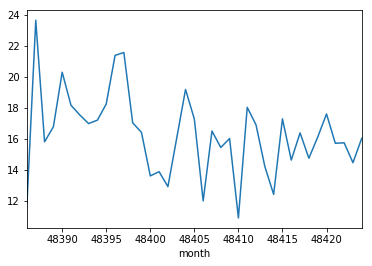

In [326]:
b=pd.read_pickle('02.ParsedData/train_2016.pkl')
b=b[b['store_nbr']=='1']
b=b[b['item_nbr']=='103665']
b['date']=b['date'].map(lambda x: datetime(1970,1,1)+timedelta(days=x))
b['month']=b['date'].map(lambda x: 24*x.year+2*x.month+int(x.day/16))
#b.index=b['date']
#b['unit_sales'].rolling(7).mean().plot(figsize=(20,10))
b.groupby('month')['unit_sales'].sum().plot()


In [319]:
b['unit_sales'].rolling(7).mean()

date
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-09         NaN
2016-01-11         NaN
2016-01-12         NaN
2016-01-13    1.359857
2016-01-14    1.301857
2016-01-15    1.333714
2016-01-16    1.333714
2016-01-17    1.212714
2016-01-18    1.311714
2016-01-19    1.410714
2016-01-20    1.195857
2016-01-21    1.294857
2016-01-22    1.362000
2016-01-23    1.541000
2016-01-24    1.613857
2016-01-25    1.613857
2016-01-26    1.613857
2016-01-27    1.671857
2016-01-28    1.787714
2016-01-29    1.589714
2016-01-30    1.640714
2016-01-31    1.509857
2016-02-01    1.410857
2016-02-02    1.384714
2016-02-03    1.326714
2016-02-04    1.210857
2016-02-05    1.425714
                ...   
2017-07-07    1.473857
2017-07-08    1.604857
2017-07-10    1.524857
2017-07-11    1.326857
2017-07-12    1.384857
2017-07-13    1.254000
2017-07-14    1.410857
2017-07-18    1.509857
2017-07-19    1.378857
2017-07-22    1.337857
2017-07-23    1.279857
2017-07-24    1.352714
2017-0

In [321]:
b.index

DatetimeIndex(['2016-01-05', '2016-01-06', '2016-01-07', '2016-01-09',
               '2016-01-11', '2016-01-12', '2016-01-13', '2016-01-14',
               '2016-01-15', '2016-01-16',
               ...
               '2017-08-03', '2017-08-04', '2017-08-05', '2017-08-06',
               '2017-08-07', '2017-08-09', '2017-08-10', '2017-08-11',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=460, freq=None)

In [268]:
from scipy.stats import linregress
linregress(ins_clean['f1'],ins_clean['log_sales'])

LinregressResult(slope=0.97606783349632187, intercept=0.23303510321102627, rvalue=0.86995423176326647, pvalue=0.0, stderr=0.00034916448771560391)

In [299]:
from sklearn.ensemble import RandomForestRegressor
idv=['f1','f2','f3','f4','f6','f7','f8']

reg=RandomForestRegressor(n_estimators=1,max_depth=3,min_samples_split=500,oob_score=True,n_jobs=-1)
reg.fit(ins_clean[idv],ins_clean['log_sales'])
print (mean_squared_error(ins_clean['log_sales'],reg.predict(ins_clean[idv])))
print (mean_squared_error(oos_clean['log_sales'],reg.predict(oos_clean[idv])))

/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.177315573083
0.344131372839


In [292]:
pd.crosstab(oos_clean['date'],oos_clean['unit_sales'].isnull())

unit_sales,False,True
date,,
2017-08-01,109379,0
2017-08-02,107398,0
2017-08-03,102231,0
2017-08-04,104174,0
2017-08-05,110880,0
2017-08-06,110834,0
2017-08-07,103859,0
2017-08-08,101137,0
2017-08-09,100984,0


In [250]:
features=pd.read_csv('06.Master/01.Master_2017-08-15_365.csv',parse_dates=['date'])
baseline=pd.read_csv('04.Submissions/04.LeaderBoard_Baseline.csv',parse_dates=['date'])

In [251]:
features.head()

,Unnamed: 0,date,id,item_nbr,onpromotion,store_nbr,unit_sales,weekday,f1,f2,...,f7,flag_holiday,flag_holiday_prev_day,flag_holiday_next_day,f8,f10,f11,f12,perishable,last_date
0,0,2017-08-15,125394228,103665,0,1,1.0,1,1.018838,1.018838,...,0.0,NaN,NaN,NaN,0,0.0,0.0,0.0,1,2017-08-15
1,1,2017-08-15,125394229,105574,0,1,4.0,1,1.607973,1.553046,...,0.0,NaN,NaN,NaN,0,0.0,0.0,0.0,0,2017-08-15
2,2,2017-08-15,125394230,105575,0,1,8.0,1,2.267901,2.264178,...,0.0,NaN,NaN,NaN,0,0.0,0.0,0.0,0,2017-08-15
3,3,2017-08-15,125394231,105577,0,1,2.0,1,0.522473,0.506713,...,0.0,NaN,NaN,NaN,0,0.0,0.0,0.0,0,2017-08-15
4,4,2017-08-15,125394232,105693,0,1,1.0,1,0.232646,0.221376,...,0.0,NaN,NaN,NaN,0,0.0,0.0,0.0,0,2017-08-15


In [252]:
baseline.head()

,Unnamed: 0,id,date,store_nbr,item_nbr,onpromotion,dow,mais,mawk,madw,unit_sales
0,0,125497040,2017-08-16,1,96995,False,2,0.126638,0.844024,0.693147,0.109601
1,1,125497041,2017-08-16,1,99197,False,2,0.206469,1.010969,0.977616,0.220984
2,2,125497042,2017-08-16,1,103501,False,2,0.000000,NaN,NaN,0.000000
3,3,125497043,2017-08-16,1,103520,False,2,0.649946,1.114774,1.175135,0.984047
4,4,125497044,2017-08-16,1,103665,False,2,1.005429,1.320085,1.282500,1.655950


In [323]:
baseline[['mais','mawk','madw','unit_sales']].mean()

mais          0.838584
mawk          1.521448
madw          1.518913
unit_sales    3.270758
dtype: float64

In [253]:

combined=pd.merge(features,baseline,on=['id','date','store_nbr','item_nbr'])
combined=combined[['id','date','store_nbr','item_nbr','f1','f2','f3','f4','onpromotion_x','mais','mawk','madw','unit_sales_y']]

In [256]:
combined.sort_values(by=['store_nbr','item_nbr']).head(30)

,id,date,store_nbr,item_nbr,f1,f2,f3,f4,onpromotion_x,mais,mawk,madw,unit_sales_y
0,125497040,2017-08-16,1,96995,0.165792,0.165792,0.154621,0.154621,0,0.126638,0.844024,0.693147,0.109601
210654,125707694,2017-08-17,1,96995,0.165792,0.165792,0.175989,0.175989,0,0.126638,0.844024,0.794513,0.126606
421308,125918348,2017-08-18,1,96995,0.165792,0.165792,0.291440,0.291440,0,0.126638,0.844024,0.943827,0.152130
631962,126129002,2017-08-19,1,96995,0.165792,0.165792,0.167190,0.167190,0,0.126638,0.844024,1.059351,0.172275
842616,126339656,2017-08-20,1,96995,0.165792,0.165792,0.132540,0.132540,0,0.126638,0.844024,0.828302,0.132332
1053270,126550310,2017-08-21,1,96995,0.165792,0.165792,0.187490,0.187490,0,0.126638,0.844024,0.895880,0.143871
1263924,126760964,2017-08-22,1,96995,0.165792,0.165792,0.045200,0.045200,0,0.126638,0.844024,0.693147,0.109601
1474578,126971618,2017-08-23,1,96995,0.165792,0.165792,0.154621,0.154621,0,0.126638,0.844024,0.693147,0.109601
1685232,127182272,2017-08-24,1,96995,0.165792,0.165792,0.175989,0.175989,0,0.126638,0.844024,0.794513,0.126606
1895886,127392926,2017-08-25,1,96995,0.165792,0.165792,0.291440,0.291440,0,0.126638,0.844024,0.943827,0.152130


In [255]:
combined[['f1','f2','f3','f4','mais','mawk','madw','unit_sales_y']].corr()

,f1,f2,f3,f4,mais,mawk,madw,unit_sales_y
f1,1.000000,0.971618,0.978224,0.955010,0.928642,0.908207,0.882252,0.575813
f2,0.971618,1.000000,0.954615,0.978474,0.912380,0.883638,0.862864,0.580159
f3,0.978224,0.954615,1.000000,0.976129,0.908662,0.889238,0.906821,0.590884
f4,0.955010,0.978474,0.976129,1.000000,0.896810,0.869323,0.886066,0.589253
mais,0.928642,0.912380,0.908662,0.896810,1.000000,0.846027,0.820987,0.591621
mawk,0.908207,0.883638,0.889238,0.869323,0.846027,1.000000,0.966905,0.599021
madw,0.882252,0.862864,0.906821,0.886066,0.820987,0.966905,1.000000,0.616305
unit_sales_y,0.575813,0.580159,0.590884,0.589253,0.591621,0.599021,0.616305,1.000000


In [242]:

if 1==1:    
    START_DATE='2017-08-15'
    START_DATE=list(map(int,START_DATE.split('-')))
    START_DATE=datetime(START_DATE[0],START_DATE[1],START_DATE[2])
    START_DATE_KEY=(START_DATE-datetime(1970,1,1)).days
    END_DATE_KEY=START_DATE_KEY-window
    train=pd.read_pickle('02.ParsedData/train_2016.pkl')
    train=train[train['store_nbr']=='1']
    train=train.set_index(['store_nbr','item_nbr','date'])
    train=train.unstack().stack().fillna({'onpromotion':1,'unit_sales':0}).reset_index()
    train=train[train['item_nbr']=='96995']
    train=train[train['date']<START_DATE_KEY]
    
    min_date=train.groupby(['store_nbr','item_nbr'])['date'].agg([np.min,np.max])
    min_date.columns=['first_date','last_date']
    
    train=train[((train['date']>=END_DATE_KEY)&(train['date']<START_DATE_KEY))]
    train=train.join(min_date['first_date'],on=['store_nbr','item_nbr'],how='inner')
    train=train[train['date']>=train['first_date']]
    train['weekday']=(train['date']-4)%7
    train['count']=1
    train['days_sold']=(train['unit_sales'].fillna(0)>0).astype(np.int64)
    
    list_onpromotion=['no_promo','promo']
    list_weekday=['mon','tue','wed','thur','fri','sat','sun']
    dim_onpromotion={0:'no_promo',1:'no_promo',2:'promo'}
    dim_weekday=dict(zip(range(7),list_weekday))


In [245]:
train=pd.read_pickle('02.ParsedData/train_2016.pkl')
train=train[train['store_nbr']=='1']
train=train.set_index(['store_nbr','item_nbr','date'])

In [246]:
train.shape

(1138492, 2)

In [249]:
train.unstack().head().fillna({'onpromotion':1,'unit_sales':0})

/data/arpit.goel/anaconda/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


unit_sales                                            \
date                    16802  16803  16804  16805  16806  16807  16808   
store_nbr item_nbr                                                        
1         1000866       0.693  0.000  0.693  0.000  0.000  0.000  0.000   
          1001305       1.099  0.000  0.000  0.000  0.000  0.000  0.000   
          1003679       0.000  0.000  0.693  1.099  1.792  2.485  0.000   
          1004545       0.000  0.693  0.000  0.693  0.000  0.000  0.000   
          1004550       2.303  0.000  2.833  3.401  2.773  2.303  3.761   

                                         ...  onpromotion                    \
date                16809  16810  16811  ...        17384 17385 17386 17387   
store_nbr item_nbr                       ...                                  
1         1000866   0.693  0.693  0.000  ...          2.0   2.0   1.0   1.0   
          1001305   0.000  0.000  0.000  ...          1.0   1.0   1.0   1.0   
          1003679   0.693  0.000  1.099  ...          1.0   1.0   1.0   1.0   
          1004545   0.000  0.000  0.000  ...          1.0   1.0   1.0   1.0   
          1004550   3.401  0.000  2.833  ...          2.0   2.0   2.0   2.0   

                                                        
date               17388 17389 17390 17391 17392 17393  
store_nbr item_nbr                                      
1         1000866    1.0   1.0   1.0   1.0   1.0   1.0  
          1001305    1.0   1.0   1.0   1.0   1.0   1.0  
          1003679    1.0   1.0   1.0   1.0   1.0   1.0  
          1004545    1.0   1.0   1.0   1.0   1.0   1.0  
          1004550    2.0   2.0   2.0   2.0   2.0   2.0  

[5 rows x 1180 columns]

In [343]:
from itertools import product
import pandas as pd
import numpy as np
import os,sys
from datetime import datetime,timedelta
from multiprocessing import Pool
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

os.chdir('/data/arpit.goel/33_GrocerySales/')

dtypes = {'id':'uint32', 'item_nbr':'int32', 'store_nbr':'int8', 'unit_sales':'float32'}
train = pd.read_csv('01.RawData/train.csv', usecols=[1,2,3,4], dtype=dtypes, parse_dates=['date'])
train['START_DATE']=pd.Timestamp('2016-07-01')
train['days_to_start_dt']=(train['date'].sub(train['START_DATE'])).dt.days
train=train[train['days_to_start_dt']>0]
train=train[train['days_to_start_dt']<=365]
train=train[train['unit_sales']>0]
train['unit_sales'] =  train['unit_sales'].apply(pd.np.log1p) #logarithm conversion
train['dow'] = train['date'].dt.dayofweek

ma_dw = train[['item_nbr','store_nbr','dow','unit_sales']].groupby(['store_nbr', 'item_nbr','dow'])['unit_sales'].mean().to_frame('madw').unstack()
ma_wk = ma_dw[['item_nbr','store_nbr','madw']].groupby(['store_nbr', 'item_nbr'])['madw'].mean().to_frame('mawk')
train.drop('dow',1,inplace=True)

# creating records for all items, in all markets on all dates
# for correct calculation of daily unit sales averages.
u_dates = train.date.unique()
u_stores = train.store_nbr.unique()
u_items = train.item_nbr.unique()
train.set_index(['date', 'store_nbr', 'item_nbr'], inplace=True)
train = train.reindex(pd.MultiIndex.from_product((u_dates, u_stores, u_items),names=['date','store_nbr','item_nbr'])).reset_index()
del u_dates, u_stores, u_items
train.loc[:, 'unit_sales'].fillna(0, inplace=True) # fill NaNs
lastdate=pd.Timestamp('2016-07-01')

#Moving Averages
ma_is = train[['item_nbr','store_nbr','unit_sales']].groupby(['item_nbr','store_nbr'])['unit_sales'].mean().to_frame('mais')

for i in [365,112,56,28,14,7,3,1]:
    tmp = train[train.days_to_start_dt<=i]
    tmpg = tmp.groupby(['item_nbr','store_nbr'])['unit_sales'].mean().to_frame('mais'+str(i))
    ma_is = ma_is.join(tmpg, how='left')

del tmp,tmpg,train

ma_is['mais']=ma_is.median(axis=1)
ma_is.reset_index(inplace=True)


AttributeError: 'Series' object has no attribute 'days'

In [354]:
ma_dw = train[['item_nbr','store_nbr','dow','unit_sales']].groupby(['item_nbr','store_nbr','dow'])['unit_sales'].mean().to_frame('madw').reset_index()


NameError: name 'train' is not defined

In [355]:
ma_dw.set_index(['item_nbr','store_nbr','dow']).unstack()

madw                                          \
dow                        0         1         2         3         4   
item_nbr store_nbr                                                     
96995    1          0.693147  0.693147  0.693147  0.693147  0.855333   
         2          0.794513  0.794513  0.693147  0.693147  0.866918   
         3          0.693147  0.693147  0.693147  0.693147  0.760725   
         4               NaN  0.693147       NaN       NaN  0.693147   
         5          0.693147  0.693147  0.693147  1.098612  0.693147   
         6          1.011404  0.794513  0.693147  0.912870  0.895880   
         7          0.693147  0.895880  0.779791  0.693147  0.993963   
         8          0.866918  0.808994  0.922220  0.895880  0.924196   
         25         0.693147  0.693147       NaN       NaN  0.693147   
         27         0.693147       NaN       NaN  0.693147       NaN   
         29         0.828302  0.828302  0.957498  0.693147  0.693147   
         36              NaN  0.794513  0.693147  0.693147  0.693147   
         37         0.963457  0.943827  0.693147  0.831777  1.027387   
         38              NaN  0.895880  1.098612  1.098612  0.693147   
         42         0.774240  0.693147  0.693147  0.693147  0.693147   
         43         0.866434  0.774240  0.866434  0.693147  0.794513   
         44         1.055740  1.133732  0.855333  0.876249  0.892232   
         45         1.023586  0.924196  0.912870  0.693147  0.693147   
         46         0.794513  0.774240  0.895880  0.828302  0.828302   
         47         1.016766  1.076068  0.992769  1.114360  1.287586   
         48         0.828302  0.693147  0.808672  0.693147  0.866434   
         49         0.693147  0.794513  0.774240  0.693147  0.693147   
         50         0.895880  0.774240  0.693147  0.895880  0.693147   
         51         0.693147  0.693147  0.895880  1.098612  0.693147   
         52         0.855333  0.693147  0.760725  0.693147  0.895880   
99197    1          0.946563  1.246999  0.937283  0.992769  0.946563   
         2          0.693147  0.866434  0.895880  0.895880  0.751071   
         3          1.535721  1.162395  1.205614  1.296565  1.196873   
         4          0.881157  0.855333  1.098612  0.693147  0.693147   
         5          0.693147  1.098612  1.098612       NaN  0.693147   
...                      ...       ...       ...       ...       ...   
2124052  23              NaN       NaN       NaN       NaN       NaN   
         24              NaN       NaN       NaN       NaN       NaN   
         25              NaN       NaN       NaN       NaN       NaN   
         26              NaN       NaN       NaN       NaN       NaN   
         27              NaN       NaN       NaN       NaN       NaN   
         28              NaN       NaN       NaN       NaN       NaN   
         29              NaN       NaN       NaN       NaN       NaN   
         30              NaN       NaN       NaN       NaN       NaN   
         31              NaN       NaN       NaN       NaN       NaN   
         32              NaN       NaN       NaN       NaN       NaN   
         33              NaN       NaN       NaN       NaN       NaN   
         34              NaN       NaN       NaN       NaN       NaN   
         35              NaN       NaN       NaN       NaN       NaN   
         36              NaN       NaN       NaN       NaN       NaN   
         37              NaN       NaN       NaN       NaN       NaN   
         38              NaN       NaN       NaN       NaN       NaN   
         40              NaN       NaN       NaN       NaN       NaN   
         41              NaN       NaN       NaN       NaN       NaN   
         42              NaN       NaN       NaN       NaN       NaN   
         43              NaN       NaN       NaN       NaN       NaN   
         44              NaN       NaN       NaN       NaN       NaN   
         45              NaN       NaN       NaN       NaN      

In [356]:
features_lb=pd.read_csv('05.Features/07.LeaderBoardSolutionFeatures_2017-07-01.csv')

In [357]:
features_lb.head()

,Unnamed: 0,Unnamed: 1,"('madw', 0)","('madw', 1)","('madw', 2)","('madw', 3)","('madw', 4)","('madw', 5)","('madw', 6)",mawk,mais,mais365,mais112,mais56,mais28,mais14,mais7,mais3,mais1
0,1,96995,1.098612,NaN,0.693147,0.895880,1.386294,1.098612,1.098612,1.045193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,99197,0.895880,1.039721,1.098612,1.039721,1.141087,0.828302,0.693147,0.962353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,103520,0.967800,1.242453,0.693147,1.268145,1.302052,0.970406,0.693147,1.019593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,103665,1.177221,1.315850,1.480306,1.298239,1.538057,1.599232,0.794513,1.314774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,105574,1.874326,1.937710,2.035674,2.014368,1.894527,1.767434,1.023586,1.792518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [358]:
train = pd.read_csv('01.RawData/train.csv', usecols=[1,2,3,4], dtype=dtypes, parse_dates=['date'],nrows=100)
train['START_DATE']=pd.Timestamp('2016-01-01')
train['days_to_start_dt']=(train['START_DATE'].sub(train['date'])).dt.days
train

,date,store_nbr,item_nbr,unit_sales,START_DATE,days_to_start_dt
0,2013-01-01,25,103665,7.0,2016-01-01,1095
1,2013-01-01,25,105574,1.0,2016-01-01,1095
2,2013-01-01,25,105575,2.0,2016-01-01,1095
3,2013-01-01,25,108079,1.0,2016-01-01,1095
4,2013-01-01,25,108701,1.0,2016-01-01,1095
5,2013-01-01,25,108786,3.0,2016-01-01,1095
6,2013-01-01,25,108797,1.0,2016-01-01,1095
7,2013-01-01,25,108952,1.0,2016-01-01,1095
8,2013-01-01,25,111397,13.0,2016-01-01,1095
9,2013-01-01,25,114790,3.0,2016-01-01,1095
